Chapter 3 - A Tour of Machine Learning Classifiers Using Scikit-Learn

# First steps with scikit-learn

In [1]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


splitting data into 70% training and 30% test data:

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [3]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


Standardizing the features

In [4]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Training a perceptron via scikit-learn

In [5]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [6]:
y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 1


In [7]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.978


In [8]:
print('Accuracy: %.3f' % ppn.score(X_test_std, y_test))

Accuracy: 0.978


In [15]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib version
import matplotlib
# from distutils.version import LooseVersion

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ['o', 's', '^', 'v', '<']
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100,
                    label='Test set')

Training a perceptron model using the standardized training data:

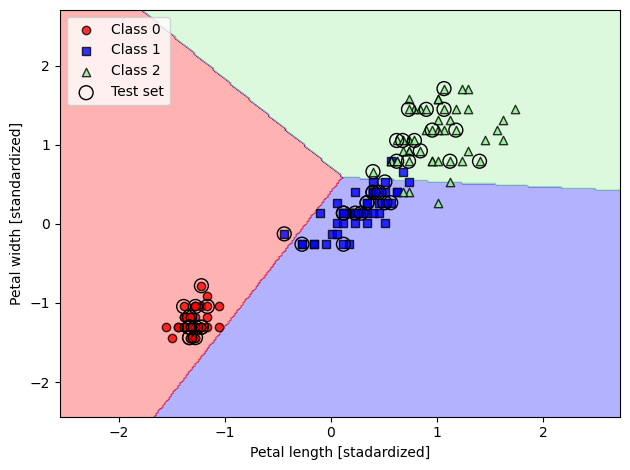

In [16]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('Petal length [stadardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Modeling class probabilities via logistic regression

Logistic regression intuition and conditional probabilities

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
C:\Users\lijie\AppData\Local\Temp\ipykernel_4748\146407127.py:11: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma(z)$')


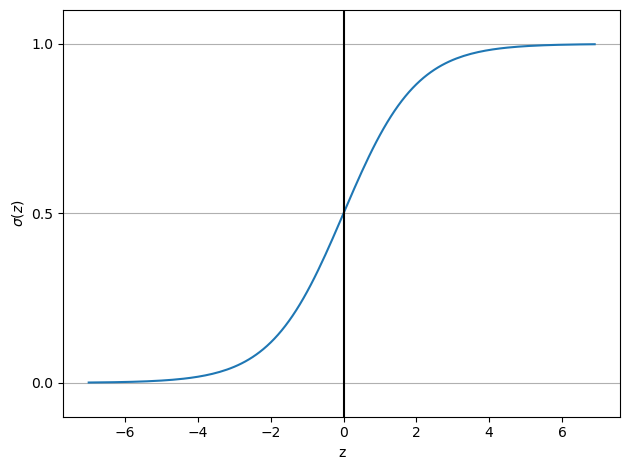

In [17]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
sigma_z = sigmoid(z)

plt.plot(z, sigma_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\sigma(z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

Learning the weights of the logistic loss function

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
C:\Users\lijie\AppData\Local\Temp\ipykernel_4748\2702719029.py:18: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(z)$')


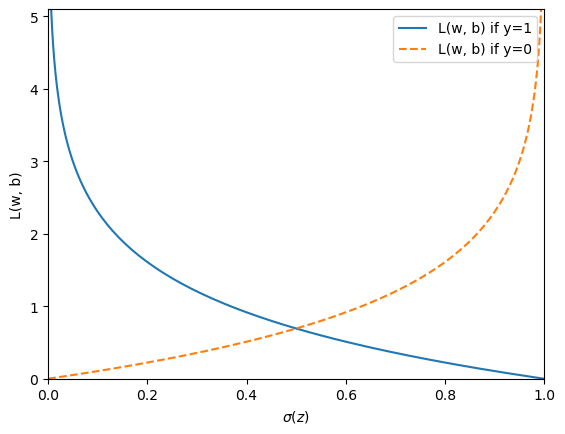

In [18]:
def loss_1(z):
    return -np.log(sigmoid(z))

def loss_0(z):
    return -np.log(1-sigmoid(z))

z = np.arange(-10,10,0.1)
sigma_z = sigmoid(z)

c1 = [loss_1(x) for x in z]
plt.plot(sigma_z, c1, label='L(w, b) if y=1')

c0 = [loss_0(x) for x in z]
plt.plot(sigma_z, c0, linestyle='--', label='L(w, b) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\sigma(z)$')
plt.ylabel('L(w, b)')
plt.legend(loc='best')
plt.show()

In [19]:
class LogisticRegressionGD:
    """Gradient descent algorithm for logistic regression.
    
    Parameters
    ----------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        Random number generator seed for random weight
        initialization.

    Attributes
    ----------
    w_ : 1d-array
        Weights after training.
    b_ : Scalar
        Bias unit after training.
    cost_ : list
        Log loss function value in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : Instance of LogisticRegressionGD

       """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * errors.mean()
            loss = (-y.dot(np.log(output)) - (1 - y).dot(np.log(1 - output))) / X.shape[0]
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)



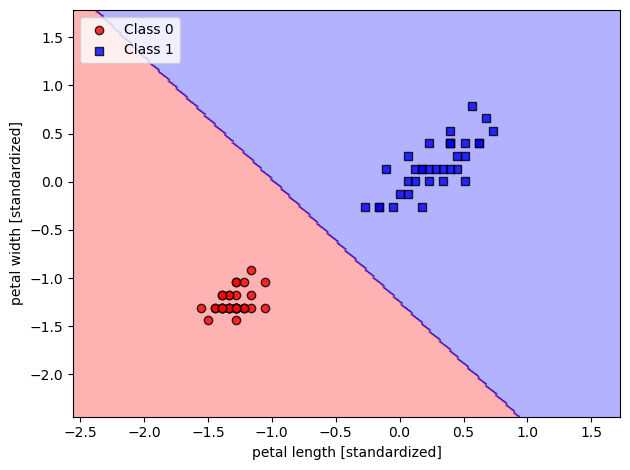

In [20]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset,
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()

plt.show()
                  

Training a logistic regression model with sickit-learn

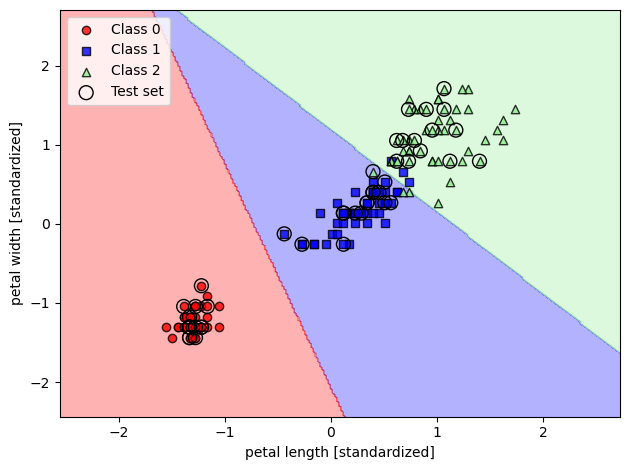

In [21]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()                

In [22]:
lr.predict_proba(X_test_std[:3,:])

array([[3.81527885e-09, 1.44792866e-01, 8.55207131e-01],
       [8.34020679e-01, 1.65979321e-01, 3.25737138e-13],
       [8.48831425e-01, 1.51168575e-01, 2.62277619e-14]])

In [23]:
lr.predict_proba(X_test_std[:3,:]).sum(axis=1)

array([1., 1., 1.])

In [24]:
lr.predict_proba(X_test_std[:3,:]).argmax(axis=1)

array([2, 0, 0], dtype=int64)

In [25]:
lr.predict(X_test_std[:3,:])

array([2, 0, 0])

In [26]:
lr.predict(X_test_std[0,:].reshape(1,-1))

array([2])

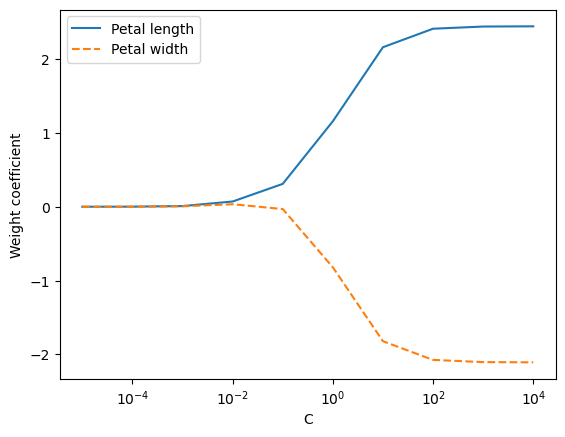

In [27]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c,
                            multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='Petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='Petal width')
plt.ylabel('Weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
#plt.savefig('figures/03_08.png', dpi=300)
plt.show()

# Maximum margin classification with support vector machines

Dealing with the nonlinearly separable case using slack variables

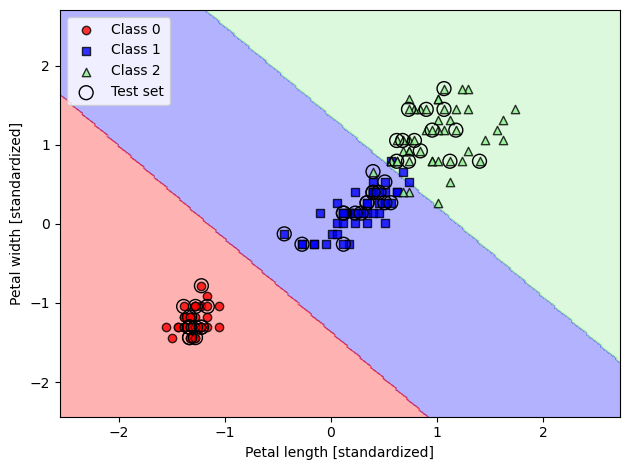

In [28]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [29]:
from sklearn.linear_model import SGDClassifier

ppn = SGDClassifier(loss='perceptron')
lr = SGDClassifier(loss='log')
svm = SGDClassifier(loss='hinge')

Solving non-linear problems using a kernel SVM

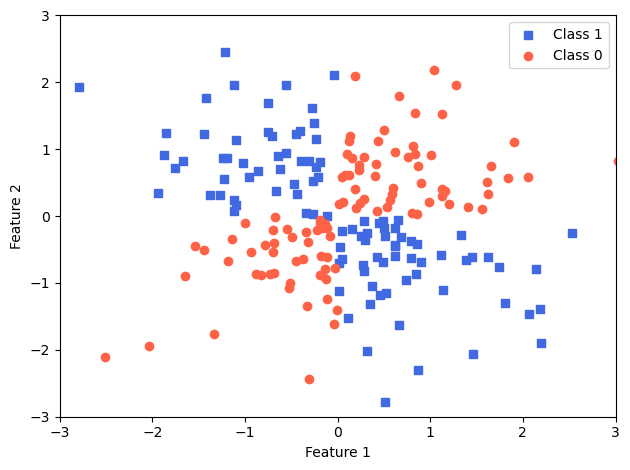

In [30]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='royalblue',
            marker='s',
            label='Class 1')
plt.scatter(X_xor[y_xor == 0, 0],
            X_xor[y_xor == 0, 1],
            c='tomato',
            marker='o',
            label='Class 0')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.legend(loc='best')
plt.tight_layout()
plt.show()

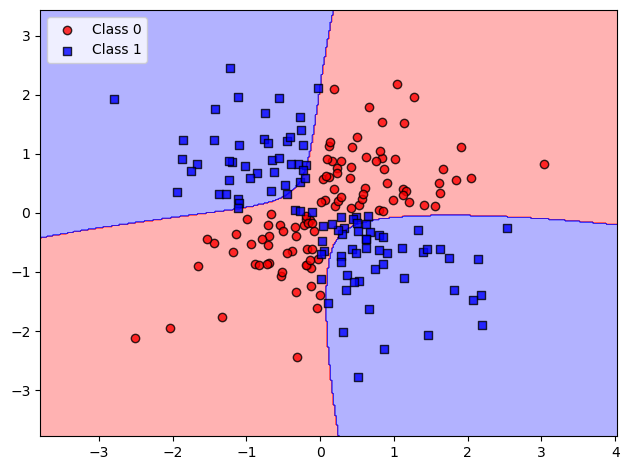

In [31]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_14.png', dpi=300)
plt.show()

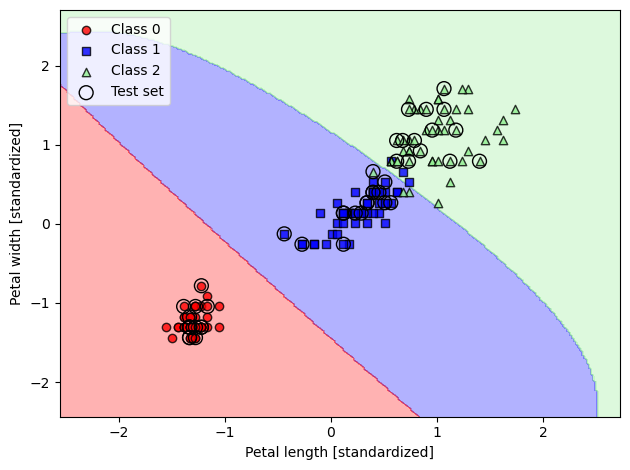

In [32]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_15.png', dpi=300)
plt.show()

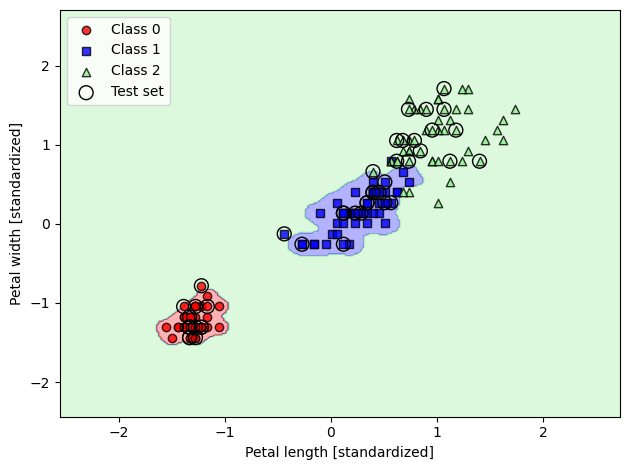

In [33]:
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_16.png', dpi=300)
plt.show()

# Decision tree learning

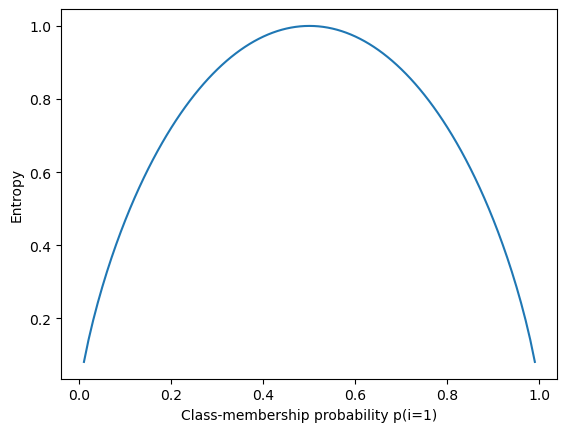

In [34]:
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None 
       for p in x]

plt.ylabel('Entropy')
plt.xlabel('Class-membership probability p(i=1)')
plt.plot(x, ent)
#plt.savefig('figures/03_26.png', dpi=300)
plt.show()

Maximizing information gain - getting the most bang for the buck

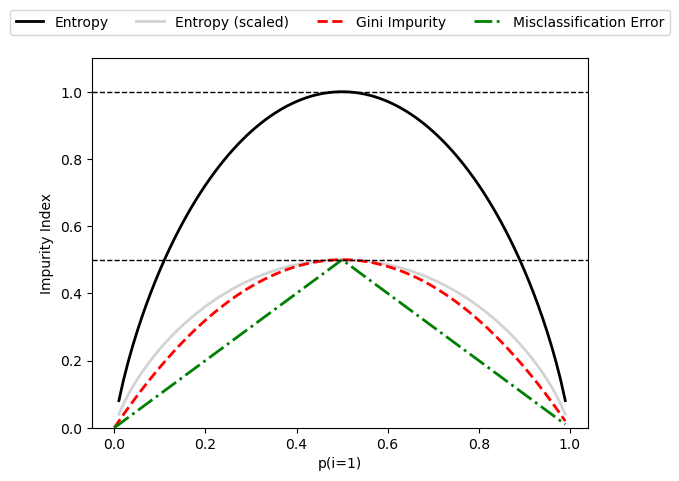

In [35]:
def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))

def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1-p))

def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c in zip([ent, sc_ent, gini(x), err],
                         ['Entropy', 'Entropy (scaled)',
                          'Gini Impurity', 'Misclassification Error'],
                         ['-', '-', '--', '-.'],
                         ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.show()

Building a decision tree

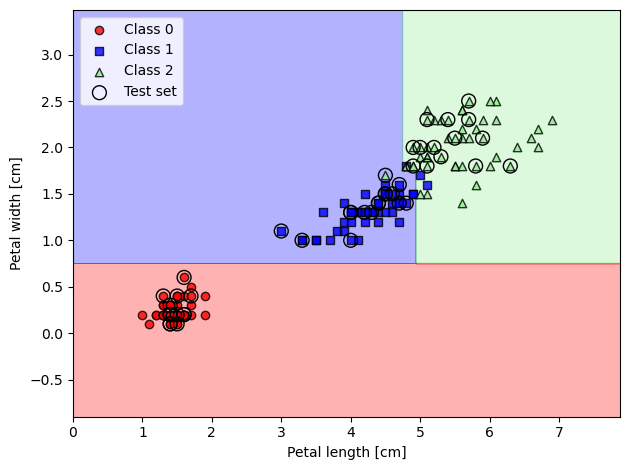

In [36]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=4, 
                                    random_state=1)
tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree_model,
                      test_idx=range(105, 150))

plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

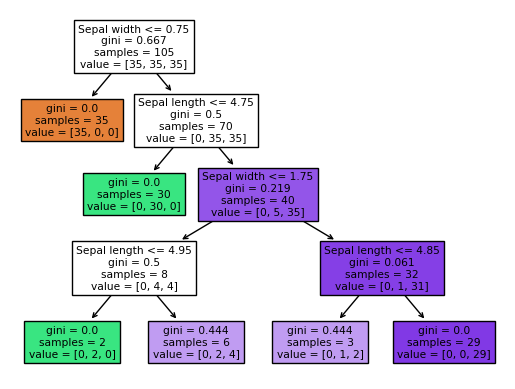

In [37]:
from sklearn import tree

feature_names = ['Sepal length', 'Sepal width',
                 'Petal length', 'Petal width']

tree.plot_tree(tree_model, feature_names=feature_names,
               filled=True)

plt.show()

Combining weak to strong learners via random forests

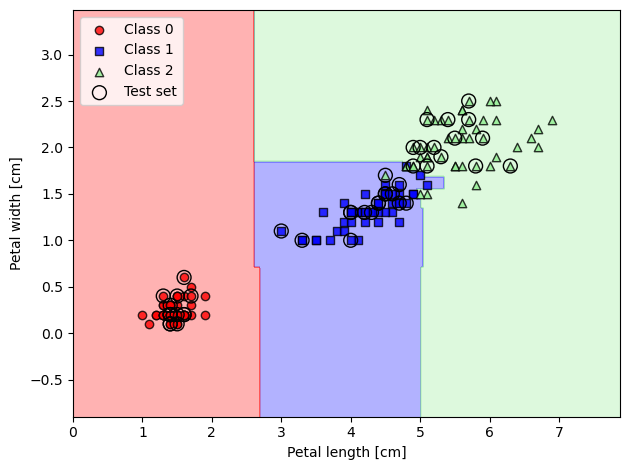

In [38]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_2.png', dpi=300)
plt.show()

K-nearest neighbors - a lazy learning algorithm

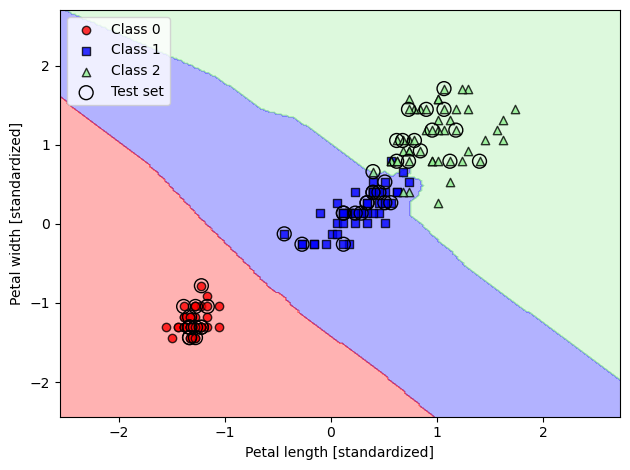

In [39]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_24_figures.png', dpi=300)
plt.show()